In [1]:
import pandas as pd 

In [2]:
dataset=pd.read_excel("data/data_test.xlsx")

In [3]:
df=pd.read_excel("data/data_200_300.xlsx")

In [4]:
df1=pd.read_excel("data/data_300_400.xlsx")

In [5]:
dataset=pd.concat([dataset,df,df1],ignore_index=True)

In [6]:
dataset=dataset.drop("Unnamed: 0",axis=1)

In [7]:
dataset=dataset.drop_duplicates()

In [13]:
dataset.to_excel("data/data_preview.xlsx")

In [9]:
dataset.head(2)

,Photo produit 1,Photo produit 2,Nom produit,Lien achat,Catégorie produit,Genre,cielab_colors
0,https://wasted.fr/cdn/shop/files/t-shirt-acid-...,-,T-Shirt Acid,https://wasted.fr/collections/t-shirts-homme/p...,T-shirt,H/F,"[[10.588235294117647, 0.0, 1.0]]"
1,https://wasted.fr/cdn/shop/files/t-shirt-happy...,-,T-Shirt Happy When it Rains,https://wasted.fr/collections/t-shirts-homme/p...,T-shirt,H/F,"[[10.588235294117647, 0.0, 0.0]]"


In [10]:
dataset.columns

Index(['Photo produit 1', 'Photo produit 2 ', 'Nom produit ', 'Lien achat',
       'Catégorie produit', 'Genre', 'cielab_colors'],
      dtype='object')

In [12]:
dataset=dataset.dropna()

In [14]:
import ast 

dataset["cielab_colors"]=dataset["cielab_colors"].apply(ast.literal_eval)

In [15]:
data=dataset.explode("cielab_colors").reset_index(drop=True)

In [16]:
data.shape


(2125, 7)

In [17]:
import faiss
import numpy as np

# --------------------------------------
# 1. Prepare Data for FAISS
# --------------------------------------
# Extract all color vectors as a numpy array
all_colors = np.array(data["cielab_colors"].tolist(), dtype="float32")

# Create a FAISS index (L2 distance for CIELAB)
dim = 3 # L, a, b
index = faiss.IndexFlatL2(dim)
index.add(all_colors)


In [19]:
faiss.write_index(index,"vector_store/faiss_index.idx")

In [20]:
# --------------------------------------
# 2. Query Function
# --------------------------------------
def find_matching_products(query_colors, index, df, top_k=5):
    query_colors = np.array(query_colors, dtype="float32")
    distances, indices = index.search(query_colors, top_k)

    # Collect all matching product IDs and their distances
    matches = []
    for i, query in enumerate(query_colors):
        for j in range(top_k):
            product_id = df.iloc[indices[i][j]]["Photo produit 1"]
            distance = distances[i][j]
            matches.append((product_id, distance))

    # Group by Product ID and keep the best (min) distance
    product_distances = {}
    for product_id, distance in matches:
        if product_id not in product_distances or distance < product_distances[product_id]:
            product_distances[product_id] = distance

    # Sort products by distance
    sorted_products = sorted(product_distances.items(), key=lambda x: x[1])
    return sorted_products[:top_k]


In [171]:
# --------------------------------------
# 3. Example Usage
# --------------------------------------
# Input: Assume 2 dominant colors
query_colors = query_color = [[63.921568627450974, -5.0, -17.0]] # Example CIELAB vectors
matches = find_matching_products(query_colors, index, data, top_k=5)


In [172]:
matches

[('https://wasted.fr/cdn/shop/files/varsity-jacket-prey-742723.jpg?v=1737390429',
  np.float32(0.0)),
 ('https://ntmb.it/cdn/shop/products/jeans-baggy-reworked-blue-311475.jpg?v=1694471080&width=3000',
  np.float32(7.8446774)),
 ('https://nestorevintage.fr/cdn/shop/files/055917A6-267F-48CA-87FE-973C1946E906.jpg?v=1725801192&width=2048',
  np.float32(14.384086)),
 ('https://fr.sandro-paris.com/dw/image/v2/BCMW_PRD/on/demandware.static/-/Sites-master-catalog/default/dwcd63739a/images/packshot/Sandro_SHPBE00082-40_H_P.jpg?sw=650&sh=650',
  np.float32(16.153788)),
 ('https://nestorevintage.fr/cdn/shop/files/IMG_23132.jpg?v=1715529282&width=2048',
  np.float32(18.384087))]

In [173]:
from sklearn.neighbors import NearestNeighbors

In [174]:
nn=NearestNeighbors(n_neighbors=5,metric="euclidean")

In [175]:
nn.fit(all_colors)

NearestNeighbors(metric='euclidean')

In [179]:
def find_matching_products_nn(query_colors, nn_model, df, top_k=5):
    query_colors = np.array(query_colors, dtype="float32")
    distances, indices = nn_model.kneighbors(query_colors)

    # Collect all matching product IDs and their distances
    matches = []
    for i, query in enumerate(query_colors):
        for j in range(top_k):
            product_id = df.iloc[indices[i][j]]["Photo produit 1"]
            distance = distances[i][j]
            matches.append((product_id, distance))

    # Group by Product ID and keep the best (min) distance
    product_distances = {}
    for product_id, distance in matches:
        if product_id not in product_distances or distance < product_distances[product_id]:
            product_distances[product_id] = distance

    # Sort products by distance
    sorted_products = sorted(product_distances.items(), key=lambda x: x[1])
    return sorted_products[:top_k]


In [185]:
query_colors = query_color = [[83.13725490196079, 0.0, 0.0], [70.58823529411765, 0.0, 0.0]] # Example CIELAB vectors
matches = find_matching_products(query_colors, index, data, top_k=5)

In [186]:
matches

[('https://wasted.fr/cdn/shop/files/crewneck-negative-617699_2048x2048.jpg?v=1712661665',
  np.float32(0.0)),
 ('https://wasted.fr/cdn/shop/products/jean-casper-snow-feeler-762622.jpg?v=1706147807',
  np.float32(0.0)),
 ('https://wasted.fr/cdn/shop/files/t-shirt-united-930779_2048x2048.jpg?v=1730548101',
  np.float32(0.1537883)),
 ('https://wasted.fr/cdn/shop/products/hoodie-zip-crown-pitcher-736902_2048x2048.jpg?v=1689958848',
  np.float32(0.1537883)),
 ('https://wasted.fr/cdn/shop/files/jean-casper-signature-610785.jpg?v=1737390239',
  np.float32(0.1537883))]

In [187]:
dataset.iloc[140,][0]

C:\Users\BahaARFAOUI\AppData\Local\Temp\ipykernel_15116\271524657.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset.iloc[140,][0]


'https://wasted.fr/cdn/shop/products/jean-casper-snow-feeler-762622.jpg?v=1706147807'

In [68]:
data_preview=pd.read_excel("data/data_preview.xlsx")

In [69]:
data_preview=data_preview.drop("Unnamed: 0",axis=1)

In [70]:
products=data_preview["Catégorie produit"].unique().tolist()

In [28]:
for item in products:
    print(f"{item}")

T-shirt
Hoodie
Pull
Jean
Pantalon
Jogging
Veste
Doudoune
Jupe
Bonnet
Casquette
Chapeau
Short
Chemise
Pantalon habillé
Chino
short
Blazer
Robe
Manteau
Blouson
Trench
Cardigan
Col roulé
Top
top
Débardeur
chemise
t shirt 
body
t shirt
jean
pantalon habillé
jupe
sneakers
botte
Chaussures de ville
bottes
escarpin
Bottes
T-Shirt
Écharpe
Portefeuille
Sac bandoulière
Sac à main
Sac de voyage
Lunettes
Sac à dos
Veste 
Bob


In [157]:
import yaml
from pyprojroot import here
with open(here("colorfact/configs/outfit.yaml")) as cfg:
            outfit = yaml.load(cfg, Loader=yaml.FullLoader)

In [159]:
outfit

{'Ontologie': {'Hauts': 'T-shirt, Polo, Chemise, Col-roulé, Sweatshirt, Hoodie, Pull, Cardigan, Veste, Blouson, Manteau, Parka, Trench',
  'Bas': 'Pantalons, Jean, Short, Jogging, Chinos, Jupe , Robe, Combinaison',
  'Ensembles habillés': 'Costume, Tailleur, Pantalon habillé, Blazer, Robe de soirée',
  'Chaussures': 'Sneakers, Bottes, Chaussures de ville, Escarpins, Talons, Sandales',
  'Accessoires': 'Sac à main, Sac à dos, Lunettes, Bonnet, Casquettes, Ceinture, Montre'},
 'Outfit': {'T-shirt': {'Casual été': ['Jean', 'Lunettes', 'Sneakers'],
   'Casual hiver': ['Jean',
    'Sneakers',
    'Cardigan',
    'Parka',
    'Manteau',
    'Bonnet'],
   'Sportswear': ['Jogging', 'Sneakers', 'Hoodie', 'Casquettes'],
   'Professionnel': ['Chaussures de ville',
    'Pantalons',
    'Blazer',
    'Ceinture']},
  'Polo': {'Casual été': ['Jean', 'Lunettes', 'Sneakers'],
   'Casual hiver': ['Jean',
    'Sneakers',
    'Cardigan',
    'Parka',
    'Manteau',
    'Bonnet'],
   'Sportswear': ['Cargo'

In [160]:
outfit["Outfit"]['Trench']

{'Casual 1': ['Col roulé', 'Bottes', 'Pantalon', 'Bonnet'],
 'Casual 2': ['Sweatshirt', 'Jean', 'Sneakers', 'Bonnet'],
 'Sportswear': ['Jogging',
  'Cargo',
  'Sneakers',
  'Sweatshirt',
  'Hoodie',
  'Casquette'],
 'Professionnel': ['Costume', 'Col roulé', 'Chemise', 'Mocassins', 'Ceinture']}

In [117]:
cat=list(outfit["Ontologie"].values())

In [118]:
cat=[item.split(',') for item in cat]

In [119]:
cat=[item.strip() for sublist in cat for item in sublist]

In [120]:
cat

['T-shirt',
 'Polo',
 'Chemise',
 'Col-roulé',
 'Sweatshirt',
 'Hoodie',
 'Pull',
 'Cardigan',
 'Veste',
 'Blouson',
 'Manteau',
 'Parka',
 'Trench',
 'Pantalons',
 'Jean',
 'Short',
 'Jogging',
 'Chinos',
 'Jupe',
 'Robe',
 'Combinaison',
 'Costume',
 'Tailleur',
 'Pantalon habillé',
 'Blazer',
 'Robe de soirée',
 'Sneakers',
 'Bottes',
 'Chaussures de ville',
 'Escarpins',
 'Talons',
 'Sandales',
 'Sac à main',
 'Sac à dos',
 'Lunettes',
 'Bonnet',
 'Casquettes',
 'Ceinture',
 'Montre']

In [121]:
products_not_in=[item for item in products if item not in cat]

In [122]:
products_not_in

['Jupes/Robes', 'Col-roulés']

In [51]:
products

['T-shirt',
 'Hoodie',
 'Pull',
 'Jean',
 'Pantalon',
 'Jogging',
 'Veste',
 'Doudoune',
 'Jupe',
 'Bonnet',
 'Casquette',
 'Chapeau',
 'Short',
 'Chemise',
 'Pantalon habillé',
 'Chino',
 'short',
 'Blazer',
 'Robe',
 'Manteau',
 'Blouson',
 'Trench',
 'Cardigan',
 'Col roulé',
 'Top',
 'top',
 'Débardeur',
 'chemise',
 't shirt ',
 'body',
 't shirt',
 'jean',
 'pantalon habillé',
 'jupe',
 'sneakers',
 'botte',
 'Chaussures de ville',
 'bottes',
 'escarpin',
 'Bottes',
 'T-Shirt',
 'Écharpe',
 'Portefeuille',
 'Sac bandoulière',
 'Sac à main',
 'Sac de voyage',
 'Lunettes',
 'Sac à dos',
 'Veste ',
 'Bob']

In [123]:
from thefuzz import process

# Your raw product list
raw_products =products

# Standardized product categories
standard_products = cat

# Match each raw product to the closest standard category
matched_products = {product: process.extractOne(product, standard_products)[0] for product in raw_products}

# Print results
for original, matched in matched_products.items():
    print(f"{original} -> {matched}")


T-shirt -> T-shirt
Hoodie -> Hoodie
Pull -> Pull
Jean -> Jean
Pantalons -> Pantalons
Jogging -> Jogging
Veste -> Veste
Blouson -> Blouson
Jupes/Robes -> Jupe
Bonnet -> Bonnet
Casquettes -> Casquettes
Chaussures de ville -> Chaussures de ville
Short -> Short
Chemise -> Chemise
Pantalon habillé -> Pantalon habillé
Chinos -> Chinos
Blazer -> Blazer
Manteau -> Manteau
Trench -> Trench
Cardigan -> Cardigan
Col-roulés -> Col-roulé
Bottes -> Bottes
Sneakers -> Sneakers
Escarpins -> Escarpins
Sac à main -> Sac à main
Sac à dos -> Sac à dos
Lunettes -> Lunettes


In [124]:
new_products=list(matched_products.values())

In [125]:
products_not_in=[item for item in new_products if item not in cat]

In [126]:
products_not_in

[]

In [127]:
import json 
# Save matched products
with open(here("colorfact/data/product_mapping.json"), "w", encoding="utf-8") as f:
    json.dump(matched_products, f, ensure_ascii=False, indent=4)

In [152]:
# Load the mapping
with open(here("colorfact/data/product_mapping.json"), "r", encoding="utf-8") as f:
    saved_mapping = json.load(f)

# Use the mapping instead of re-matching
new_input = "Robes de soire"
standardized_output = saved_mapping.get(new_input, process.extractOne(new_input, standard_products)[0])
print(standardized_output)

T-shirt


In [133]:
data_preview.columns

Index(['Photo produit 1', 'Photo produit 2 ', 'Nom produit ', 'Lien achat',
       'Catégorie produit', 'Genre', 'cielab_colors'],
      dtype='object')

In [134]:
data_preview['Catégorie produit'] = data_preview['Catégorie produit'].map(saved_mapping)

In [135]:

standard_products = list(set(saved_mapping.values()))  # Ensure unique standard product names

data_preview['Catégorie produit'] = data_preview['Catégorie produit'].fillna(data_preview['Catégorie produit'].apply(lambda x: process.extractOne(x, standard_products)[0]))


In [136]:
products=data_preview["Catégorie produit"].unique().tolist()

In [137]:
products_not_in=[item for item in products if item not in cat]

In [138]:
products_not_in

[]

In [78]:
from dotenv import load_dotenv

In [90]:
load_dotenv()

False

In [80]:
import base64
from openai import OpenAI

client = OpenAI()

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [81]:
# Path to your image
image_path = "data/imagesremoved.png"

# Getting the Base64 string
base64_image = encode_image(image_path)

In [84]:
prompt="""  
    You are an AI model specializing in image recognition for fashion products. Your task is to analyze an image of a clothing or accessory item and classify it into a specific category from a predefined list. Additionally, determine whether the item is intended for men (H), women (F), or both (H/F). 

    Use the following list of standard product categories for classification:
    - T-shirt
    - Polo
    - Chemise
    - Col-roulés
    - Sweatshirt
    - Hoodie
    - Pull
    - Cardigan
    - Veste
    - Blouson
    - Manteau
    - Parka
    - Trench
    - Pantalons
    - Jean
    - Short
    - Jogging
    - Chinos
    - Jupes/Robes
    - Combinaisons
    - Costumes
    - Tailleurs
    - Pantalon habillé
    - Blazer
    - Robe de soirée
    - Sneakers
    - Bottes
    - Chaussures de ville
    - Escarpins
    - Talons
    - Sandales
    - Sac à main
    - Sac à dos
    - Lunettes
    - Bonnet
    - Casquettes
    - Ceinture
    - Montre

    ### **Rules for Classification**
    1. **Category Matching:**  
    - Assign the item to the closest matching category from the list above.
    - If multiple categories apply, choose the most specific one.

    2. **Gender Classification (`genre` field):**  
    - "H" if the item is primarily for men.  
    - "F" if the item is primarily for women.  
    - "H/F" if the item can be worn by both genders.  

    ### **Output Format (JSON)**
    Return the result as a structured JSON object like this:
    
    {
        "genre": "H",
        "category": "T-shirt"
    }

"""

In [95]:
from langchain_core.messages import HumanMessage 
from langchain_openai import ChatOpenAI 

In [96]:
llm=ChatOpenAI(model="gpt-4o")

In [156]:
from utils import extract_colors_image
im=extract_colors_image(image_path="data/doudoune.png")

OpenCV bindings requires "numpy" package.
Install it via command:
    pip install numpy


ImportError: cannot import name 'fastCopyAndTranspose' from 'numpy.core._multiarray_umath' (c:\Users\BahaARFAOUI\anaconda3\envs\clothes\Lib\site-packages\numpy\core\_multiarray_umath.py)

In [154]:
from PIL import Image
img = Image.open("data/doudoune.png")

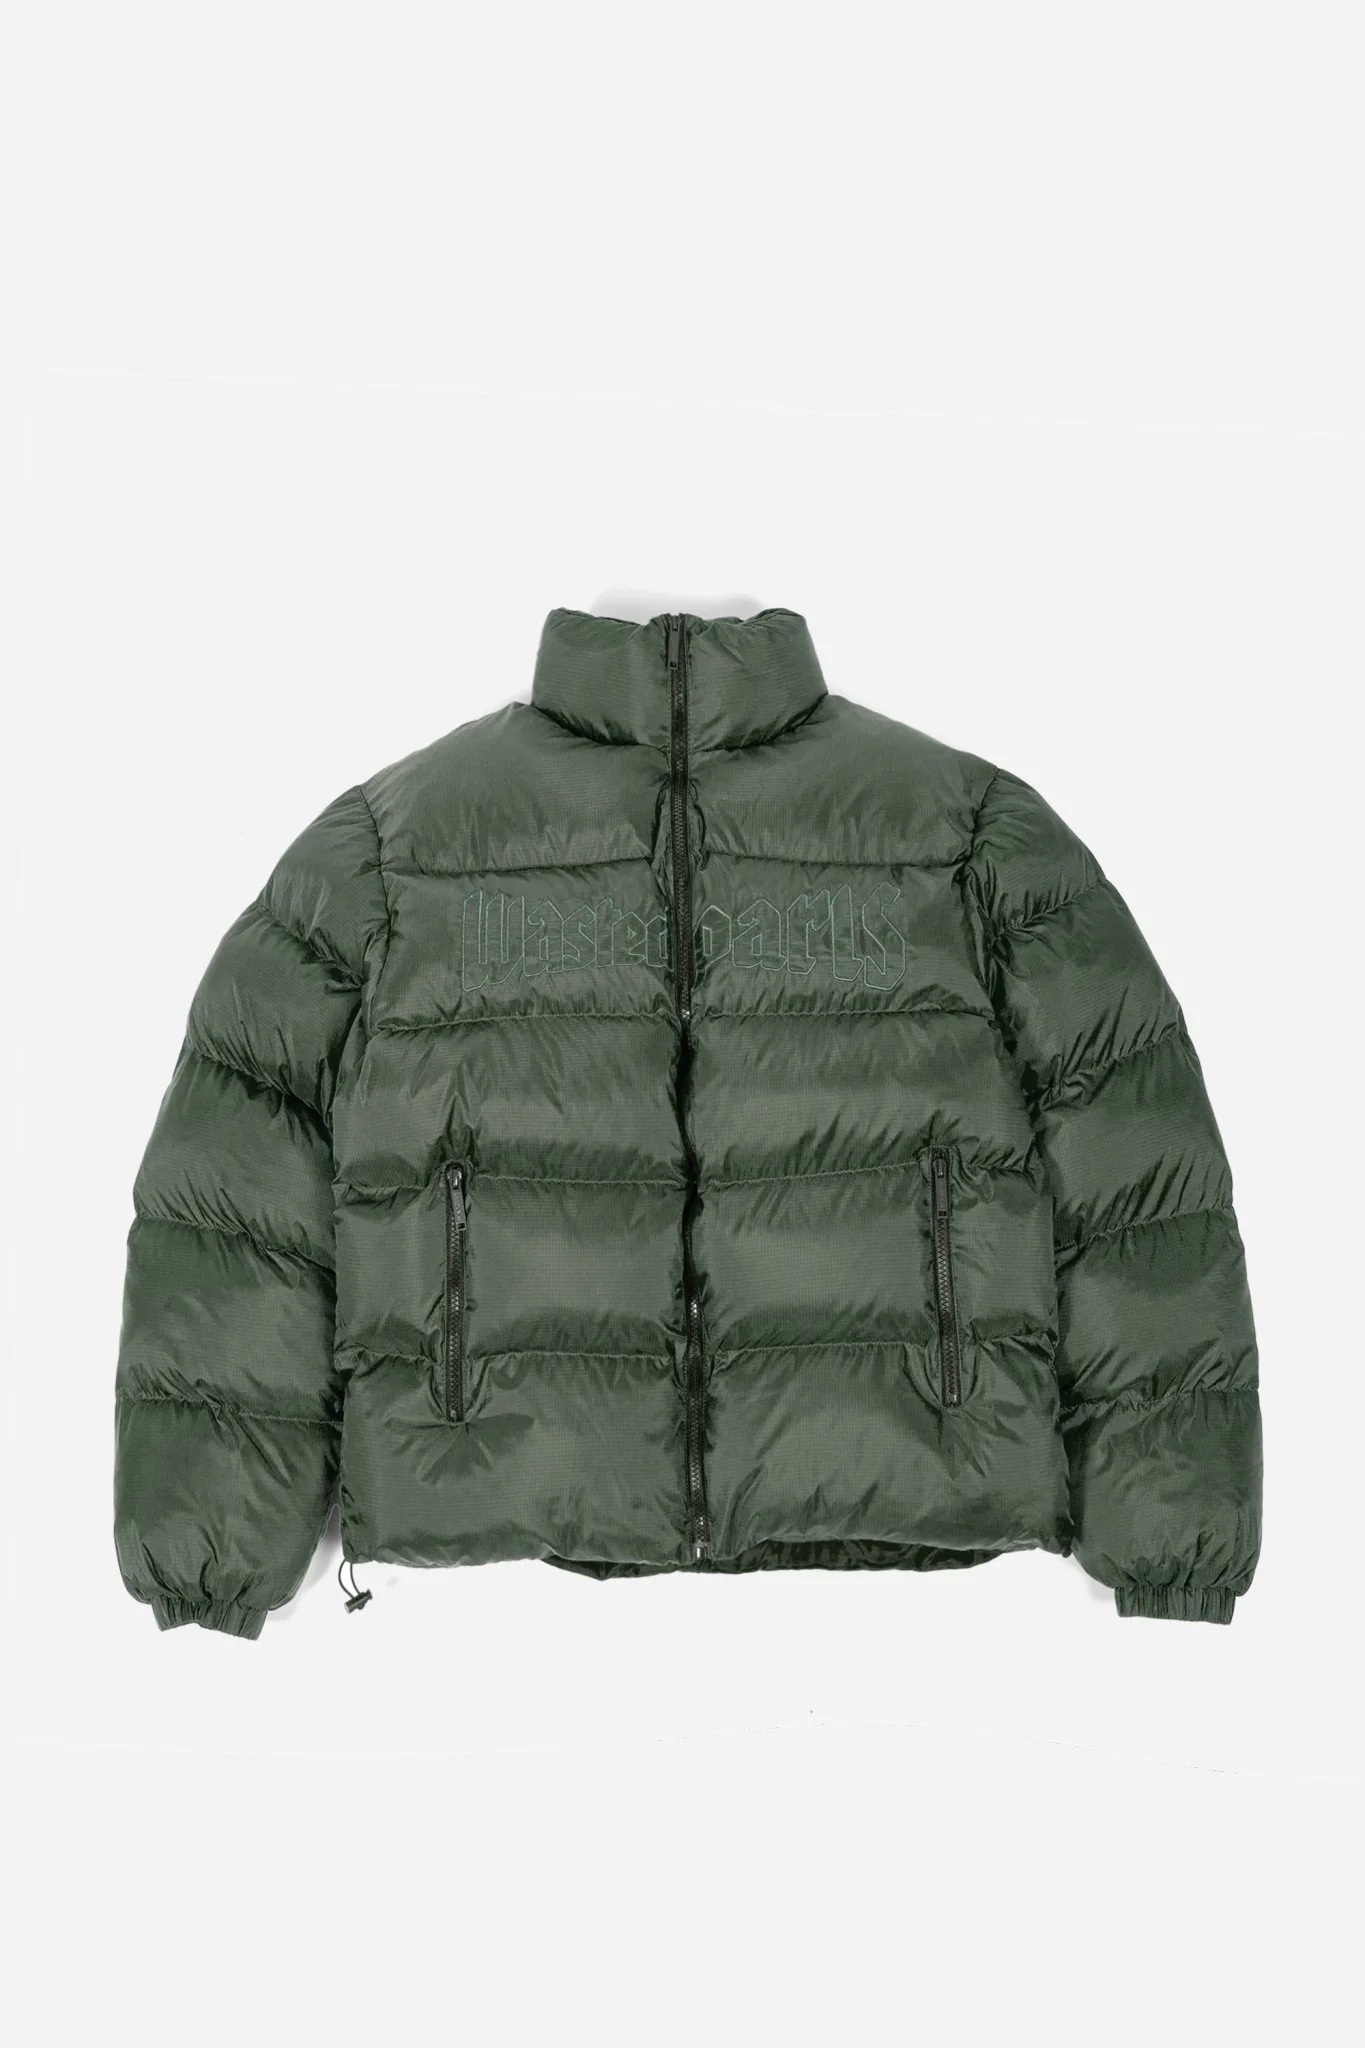

In [155]:
img

In [101]:
import ollama
def generate_image_description(model, prompt, base64_image):

    stream = ollama.generate(
        model=model,
        prompt=prompt,
        images=[base64_image], 
        stream=False
    )
    
    response = stream["response"]
    # for chunk in stream:
    #     response += chunk['response']
    return response

In [102]:
models ="llava:v1.6"
print(f"Model: {models}")
print("=" * 30)
response = generate_image_description(models, prompt, base64_image)
print(response, flush=True)
print("\n")

Model: llava:v1.6
 ```json
{
    "genre": "H/F",
    "category": "Parka"
}
``` 




In [139]:
data_preview[data_preview["Catégorie produit"]=="Parka"]

,Photo produit 1,Photo produit 2,Nom produit,Lien achat,Catégorie produit,Genre,cielab_colors


In [140]:
data_preview["Catégorie produit"].unique().tolist()

['T-shirt',
 'Hoodie',
 'Pull',
 'Jean',
 'Pantalons',
 'Jogging',
 'Veste',
 'Blouson',
 'Jupe',
 'Bonnet',
 'Casquettes',
 'Chaussures de ville',
 'Short',
 'Chemise',
 'Pantalon habillé',
 'Chinos',
 'Blazer',
 'Manteau',
 'Trench',
 'Cardigan',
 'Col-roulé',
 'Bottes',
 'Sneakers',
 'Escarpins',
 'Sac à main',
 'Sac à dos',
 'Lunettes']

In [106]:
cat

['T-shirt',
 'Polo',
 'Chemise',
 'Col-roulés',
 'Sweatshirt',
 'Hoodie',
 'Pull',
 'Cardigan',
 'Veste',
 'Blouson',
 'Manteau',
 'Parka',
 'Trench',
 'Pantalons',
 'Jean',
 'Short',
 'Jogging',
 'Chinos',
 'Jupes/Robes',
 'Combinaisons',
 'Costumes',
 'Tailleurs',
 'Pantalon habillé',
 'Blazer',
 'Robe de soirée',
 'Sneakers',
 'Bottes',
 'Chaussures de ville',
 'Escarpins',
 'Talons',
 'Sandales',
 'Sac à main',
 'Sac à dos',
 'Lunettes',
 'Bonnet',
 'Casquettes',
 'Ceinture',
 'Montre']

In [147]:
outfits_non_inclus=[item for item in cat if item not in outfits]

In [148]:
len(outfits_non_inclus)

13

In [149]:
print(outfits_non_inclus)

['Manteau', 'Bottes', 'Chaussures de ville', 'Escarpins', 'Talons', 'Sandales', 'Sac à main', 'Sac à dos', 'Lunettes', 'Bonnet', 'Casquettes', 'Ceinture', 'Montre']


In [144]:
check=[item for item in outfits if item not in cat]

In [145]:
check

[]

In [146]:
cat

['T-shirt',
 'Polo',
 'Chemise',
 'Col-roulé',
 'Sweatshirt',
 'Hoodie',
 'Pull',
 'Cardigan',
 'Veste',
 'Blouson',
 'Manteau',
 'Parka',
 'Trench',
 'Pantalons',
 'Jean',
 'Short',
 'Jogging',
 'Chinos',
 'Jupe',
 'Robe',
 'Combinaison',
 'Costume',
 'Tailleur',
 'Pantalon habillé',
 'Blazer',
 'Robe de soirée',
 'Sneakers',
 'Bottes',
 'Chaussures de ville',
 'Escarpins',
 'Talons',
 'Sandales',
 'Sac à main',
 'Sac à dos',
 'Lunettes',
 'Bonnet',
 'Casquettes',
 'Ceinture',
 'Montre']